<font color='blue'> **McDonald Valley Problem** </font> 
<font color='red'> **___ Thickness_Confining Unity Layer 04 ___** </font> 
<font color='blue'> **B_MF6** </font> 

In [1]:
import os ; import matplotlib.pyplot as plt ; import numpy as np ; import flopy ; from pathlib import Path ; import pandas as pd 
sim_ws    = Path("./w01a")   ; sim_ws.mkdir(exist_ok=True)   ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'  
datapth  = 'E:\\15_REPOS\\00_BETAMI\\bin\\Langevin'

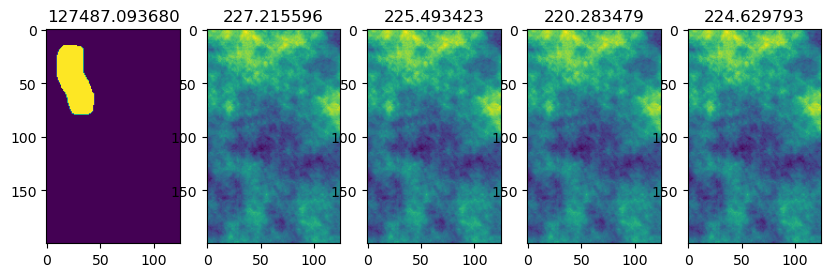

In [2]:
hk = []  ; fig, axes = plt.subplots(ncols=5, figsize=(10, 4)) ; nlay, nrow, ncol = 5, 200, 125
for k in range(nlay):
    hk_ = np.empty((nrow * ncol), float)                                   ; fname = os.path.join(datapth, 'hk{}.dat'.format(k + 1)) 
    f5 = open(fname) ; hk_ = flopy.utils.read1d(f5, hk_).reshape((nrow, ncol))                                      ; hk.append(hk_)
    ax = axes[k] ; cb = ax.imshow(hk_)                                     ;  ax.set_title('{:2f}'.format(hk_.mean()))                    

In [3]:
delr = delc = 100. ; laycon = [1, 0, 0, 0, 0]  ; bot0 = -5 ; precip = 36 ; evap = 27 ; lake_area = 1.625e7 # inches per year /  feet squared

nlay, nrow, ncol = 5, 200, 125   ; ibound0 = np.empty((nrow * ncol), int)  ; fname = os.path.join(datapth, 'ibound1.dat') 
f1 = open(fname)                 ; ibound0 = flopy.utils.read1d(f1, ibound0).reshape((nrow, ncol))          

rech = np.empty((nrow * ncol), float)                                      ; fname = os.path.join(datapth, 'rech.dat')
f2 = open(fname)                 ; rech    = flopy.utils.read1d(f2, rech).reshape((nrow, ncol))            ; rech = rech * 0.00365 
rech_aquifer = np.where(ibound0>0, rech, 0) ; rech_lake = np.where(ibound0<0, (precip - evap) / 12. / 365., 0)

thick = np.empty((nrow * ncol), float)                                     ; fname = os.path.join(datapth, 'thick3.dat')
f3 = open(fname)                 ; thick   = flopy.utils.read1d(f3, thick).reshape((nrow, ncol))             

well_info = [[1,3,18,12.05],[2,4,11,11.63],[3,7,21,12.15],[4,13,23,11.44],[5,15,12,10.86],[6,17,19,10.80],[7,18,2,9.16],[8,19,7,8.82],[9,20,12,8.86],
             [10,19,23,10.65],[11,27,6,4.26],[12,28,12,4.19],[13,29,24,7.57],[14,31,7,2.70],[15,34,15,4.59],[16,37,2,2.76],[17,38,23,6.23]]
well_info = [('W {}'.format(id)  ,col*500.-250.  ,40*500-row*500+250   ,stage) for id,row,col,stage in well_info]
dt        = np.dtype([('name', 'S15'), ('x', float), ('y', float), ('stage', float)])                ; well_info = np.array(well_info, dtype=dt)
W1 = pd.DataFrame(well_info)   ; W1.to_csv (sim_ws/ "01_well_info.csv")
W1 = pd.DataFrame(ibound0)   ; W1.to_csv (sim_ws/ "02_ibound0.csv")

idomain = [1, 1, np.where(thick==0, -1, 1), 1, 1]
vani = .01 ; kv = [hk[0] * vani, hk[1] * vani, 0.001, hk[3] * vani, hk[4] * vani]         #  ; ii, jj = np.where(ibound0 < 0)

nriv = 200 - 110  ; rivstage = np.linspace(1.79, 0.01, nriv)  ; rbot = np.linspace(-0.210, -1.99, nriv)            ; spd = []
for iriv in range(nriv):                                 spd.append([0, iriv + 110, 42, rivstage[iriv], 80000, rbot[iriv]])

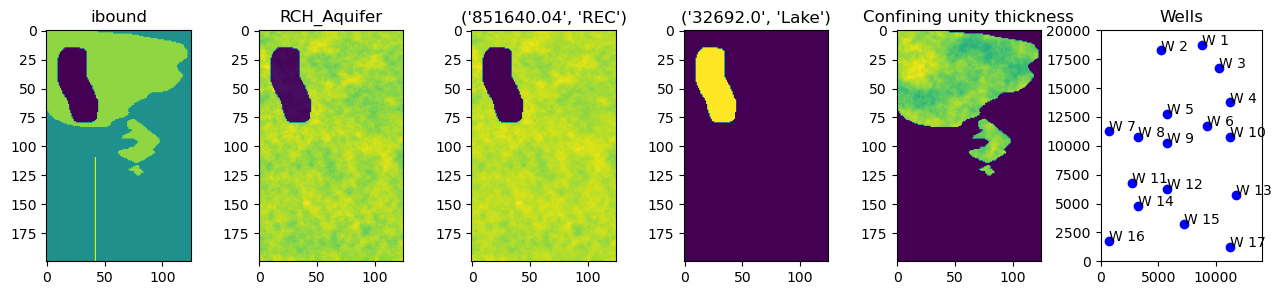

In [4]:
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(161, aspect="equal") ; plt.imshow(ibound0)       ; plt.title('ibound')
ax = fig.add_subplot(162, aspect="equal") ; plt.imshow(rech)          ; plt.title('RCH_Aquifer')
ax = fig.add_subplot(163, aspect="equal") ; plt.imshow(rech_aquifer)  ; plt.title(('{}'.format(round(rech_aquifer.sum()*100*100,2)),'REC'))
ax = fig.add_subplot(164, aspect="equal") ; plt.imshow(rech_lake)     ; plt.title(('{}'.format(round(rech_lake.sum()*100*100,0)),'Lake'))
ax = fig.add_subplot(165, aspect="equal") ; plt.imshow(thick)         ; plt.title('Confining unity thickness')
ax = fig.add_subplot(166, aspect='equal') ; ax.plot(well_info['x'], well_info['y'], 'bo') ; ax.set_xlim(0, 28 * 500) ; ax.set_ylim(0, 40 * 500)
for name, x, y, stage in well_info:     ax.text(x, y, name.decode())  ; plt.title('Wells')

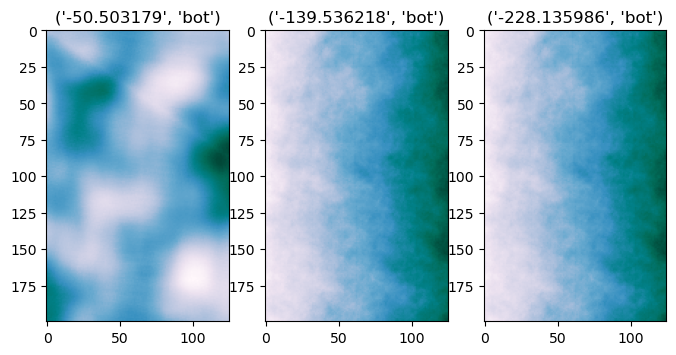

In [5]:
bot = [] ; fig, axes = plt.subplots(ncols=3, figsize=(8, 4))
for k in range(2, nlay):
    bot_ = np.empty((nrow * ncol), float)                                  ; fname = os.path.join(datapth, 'bot{}.dat'.format(k + 1)) 
    f7 = open(fname) ; bot_ = flopy.utils.read1d(f7, bot_).reshape((nrow, ncol))                                   ; bot.append(bot_)
    ax = axes[k - 2] ; cb = ax.imshow(bot_, cmap='PuBuGn')                 ; ax.set_title(('{:2f}'.format(bot_.mean()),'bot'))

In [6]:
sim = flopy.mf6.MFSimulation(sim_ws=sim_ws, exe_name='mf6')
flopy.mf6.ModflowTdis(sim)
gwf = flopy.mf6.ModflowGwf(sim)
flopy.mf6.ModflowIms     (sim, print_option='summary',outer_maximum=50, inner_maximum=500,relaxation_factor=0.97)
flopy.mf6.ModflowGwfdis  (gwf, nrow=nrow, ncol=ncol, nlay=nlay,delr=100., delc=100.,top=100., botm=[-5.,-50.,-50.-thick,bot[-2],bot[-1]],idomain=idomain)
#flopy.mf6.ModflowGwfchd  (gwf, stress_period_data=[[(0, i, j), 11.] for i, j in zip(ii, jj)])  # 
flopy.mf6.ModflowGwfic   (gwf, strt=11.)
flopy.mf6.ModflowGwfnpf  (gwf, k=hk, k33=kv)
flopy.mf6.ModflowGwfriv  (gwf, stress_period_data=spd, pname='STRAIGHTRIVER')
flopy.mf6.ModflowGwfrcha (gwf, recharge=rech_lake, pname='LAKE-RECH', filename='model.rch1')
flopy.mf6.ModflowGwfrcha (gwf, recharge=rech_aquifer, pname='AQUIFER-RECH', filename='model.rch2')
flopy.mf6.ModflowGwfoc   (gwf, head_filerecord='model.hds', saverecord={0: [('head', 'all')]})
OBS = [[name.decode(), 'head', (0, *gwf.modelgrid.intersect(x, y))] for name, x, y, stage in well_info]             ; OBS = {'m_OBS.csv': OBS}
#OBS = {}  ; obslist = [["h1_13_8", "head", (2, 12, 7)]]    ; OBS[f"{sim_name}.obs.head.csv"] = obslist
obs = flopy.mf6.ModflowUtlobs(gwf, continuous= OBS )        
sim.write_simulation(silent=True) ; sim.run_simulation(silent=True)

(True, [])

In [7]:
hdobj = flopy.utils.HeadFile(os.path.join(sim_ws, 'model.hds'), precision='double')  ; head = hdobj.get_data()
fname = os.path.join(sim_ws, 'm_OBS.csv')                                            ; OBS_csv = np.genfromtxt(fname, delimiter=',', names=True)  
residuals = []
for id, (name, tp, cellid) in enumerate(OBS['m_OBS.csv']):    residuals.append( head[0, cellid[1] ,cellid[2]]-well_info['stage'][id])

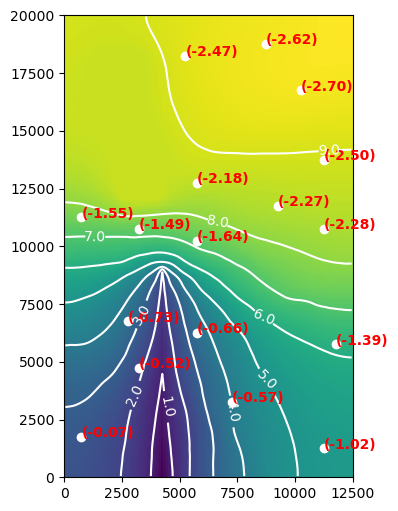

In [8]:
fig = plt.figure(figsize=(6, 6))                    ; ax = fig.add_subplot(1, 1, 1, aspect='equal')
pmv = flopy.plot.PlotMapView(gwf)                   ; pmv.plot_array(head) ; cs = pmv.contour_array(head, levels=np.arange(20), colors='white')
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.1f')

ax.plot(well_info['x'], well_info['y'], 'wo')
for id, (name, x, y, stage) in enumerate(well_info):
    r = residuals[id] ;     color = 'red'
    if r > 0:               color = 'blue'
    ax.text(x, y, '({:.2f})'.format(r), color=color, fontweight='bold')

-50.503179200000005 -228.1359856 -139.53621839999997 -50.503179200000005
127487.09367999998 224.6297932 220.28347920000002 225.49342280000002
______________________
thickness_Confinning unit [[1.47 1.5  1.41 ... 0.   0.   0.  ]
 [1.46 1.42 1.38 ... 0.   0.   0.  ]
 [1.43 1.41 1.35 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


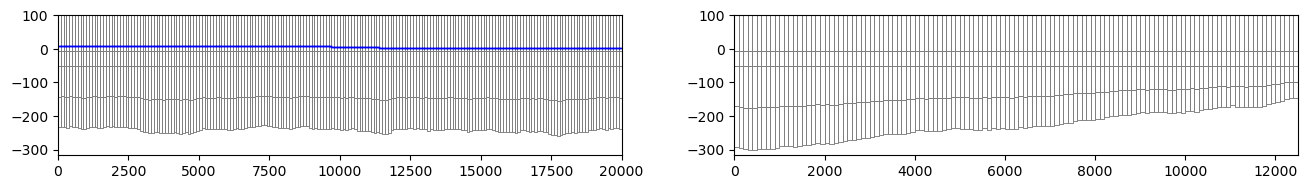

In [9]:
from flopy.utils.postprocessing import get_water_table ; wt = get_water_table(head)
irow, icol = gwf.modelgrid.intersect(5000, 100)  
def beta_plot(ax):
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax1, line={"column": icol}) ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive() ; pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=1) 
    pmv=flopy.plot.PlotCrossSection(model=gwf,ax=ax2,line={"row": irow})     ; pmv.plot_grid(linewidth=0.5) ; pmv.plot_inactive() #; pmv.plot_surface(wt, masked_values=[1e30], color="blue", lw=1) 
plt.figure(figsize=(16,4))    ;ax1 = plt.subplot2grid((2,2),(0,0),colspan=1,rowspan=1); ax2 = plt.subplot2grid((2,2),(0,1),colspan=2,rowspan=1)    ; beta_plot(ax1) ; beta_plot(ax2) 
print(bot[0].mean(), bot[-1].mean(), bot[-2].mean(), bot[-3].mean())
print(hk[0].mean() , hk[-1].mean() , hk[-2].mean() , hk[-3].mean()) ; print('______________________') ; print('thickness_Confinning unit', thick)

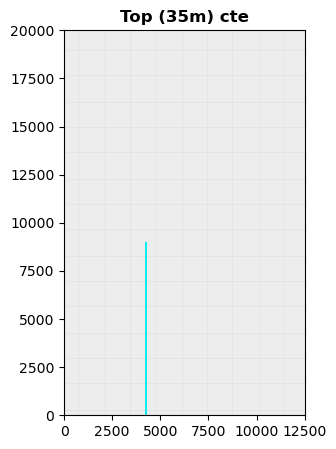

In [14]:
fig = plt.figure(figsize=(10, 5))                             
ax1 = fig.add_subplot(111) ; mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent) ; mm.plot_grid(lw=0.1) 
mm.plot_bc("RIV" , color="cyan") ; ax1.set_title("Top (35m) cte", fontweight='bold')  

plt.show()

<font color='red'> **BUD_get ?** </font> **MF6**

In [11]:
#fname = os.path.join(sim_ws, 'model' + '.bud')                   ; budobj = flopy.utils.CellBudgetFile(fname)

#fig = plt.figure(figsize=(15, 4)) ; ax = fig.add_subplot(1, 1, 1)
#ax.plot(abs(riv0['q']), label='No Pumping') ; ax.plot(abs(riv1['q']), label='Scenario 1') ; ax.plot(abs(riv2['q']), label='Scenario 2')
#ax.legend() ; ax.set_xlabel('Length along river (ft)') ; ax.set_ylabel('Discharge to river (ft^3/day)')